In [ ]:
!pip install kagglehub matplotlib opencv-python numpy torch torchvision torchaudio torchmetrics tqdm


In [1]:
import kagglehub
import shutil
import os
import random
from glob import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchmetrics.segmentation import MeanIoU
from torchmetrics.functional.classification import accuracy

In [2]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
# Mount Google Drive to persist data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#  Kaggle Authentication
from google.colab import files
print("Upload your kaggle.json file")
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API configured")

Upload your kaggle.json file


Saving kaggle.json to kaggle.json
Kaggle API configured


In [5]:
path = kagglehub.dataset_download("ransakaravihara/aerial-imagery-semantic-segmentation-dataset")
print("Downloaded to temporary folder:", path)

--- 1. Data Download and Organization ---


100%|██████████| 55.4M/55.4M [00:00<00:00, 215MB/s]

Extracting files...


Downloaded to temporary folder: /root/.cache/kagglehub/datasets/ransakaravihara/aerial-imagery-semantic-segmentation-dataset/versions/1


In [6]:
# Define target path in Google Drive for persistence
base_data_dir = '/content/drive/MyDrive/satellite_segmentation_data'
target_path_raw = os.path.join(base_data_dir, 'raw')

In [7]:
os.makedirs(target_path_raw, exist_ok=True)

In [8]:
# Copy files from KaggleHub temporary path to target raw data directory
for root, dirs, files in os.walk(path):
    for file in files:
        source_file = os.path.join(root, file)
        rel_path = os.path.relpath(source_file, path)
        destination_file = os.path.join(target_path_raw, rel_path)
        os.makedirs(os.path.dirname(destination_file), exist_ok=True)
        shutil.copy2(source_file, destination_file)

print(f"Dataset moved to: {target_path_raw}")

Dataset moved to: /content/drive/MyDrive/satellite_segmentation_data/raw


In [10]:
# Data Splitting
# Source paths in raw folder
RAW_IMAGES_DIR = os.path.join(target_path_raw, 'images')
RAW_MASKS_DIR = os.path.join(target_path_raw, 'masks')

In [11]:
# Target directories for splits
TRAIN_IMAGES_DIR = os.path.join(base_data_dir, 'train', 'images')
TRAIN_MASKS_DIR = os.path.join(base_data_dir, 'train', 'masks')
VAL_IMAGES_DIR = os.path.join(base_data_dir, 'validation', 'images')
VAL_MASKS_DIR = os.path.join(base_data_dir, 'validation', 'masks')
TEST_IMAGES_DIR = os.path.join(base_data_dir, 'test', 'images')
TEST_MASKS_DIR = os.path.join(base_data_dir, 'test', 'masks')

In [12]:
# Create directories
for folder in [TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, VAL_IMAGES_DIR, VAL_MASKS_DIR, TEST_IMAGES_DIR, TEST_MASKS_DIR]:
    os.makedirs(folder, exist_ok=True)

In [13]:
# List image files and split
image_files = glob(os.path.join(RAW_IMAGES_DIR, '*.jpg'))
print(f"Total images found: {len(image_files)}")
random.shuffle(image_files)  # Shuffle for random split

Total images found: 1305


In [14]:
# Split ratios
total = len(image_files)
train_count = int(0.7 * total)
val_count = int(0.15 * total)
test_count = total - train_count - val_count

train_files = image_files[:train_count]
val_files = image_files[train_count:train_count+val_count]
test_files = image_files[train_count+val_count:]

In [15]:
def copy_files(file_list, src_mask_dir, tgt_img_dir, tgt_mask_dir):
    for img_path in file_list:
        filename = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(tgt_img_dir, filename))
        mask_path = os.path.join(src_mask_dir, filename)
        if os.path.exists(mask_path):
            shutil.copy(mask_path, os.path.join(tgt_mask_dir, filename))
        else:
            print(f"⚠️ Mask not found for {filename}")

In [16]:
# Copy files to respective folders
copy_files(train_files, RAW_MASKS_DIR, TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR)
print(f"Copied {len(train_files)} train images and masks")
copy_files(val_files, RAW_MASKS_DIR, VAL_IMAGES_DIR, VAL_MASKS_DIR)
print(f"Copied {len(val_files)} validation images and masks")
copy_files(test_files, RAW_MASKS_DIR, TEST_IMAGES_DIR, TEST_MASKS_DIR)
print(f"Copied {len(test_files)} test images and masks")

Copied 913 train images and masks
Copied 195 validation images and masks
Copied 197 test images and masks



--- 3. Visualize Random Image + Mask Pairs ---


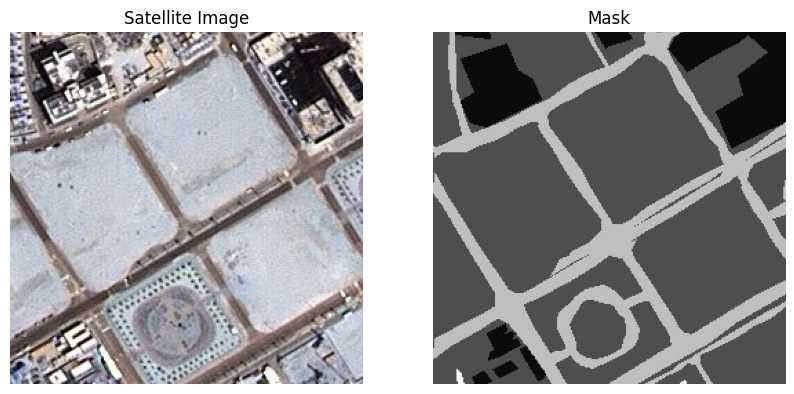

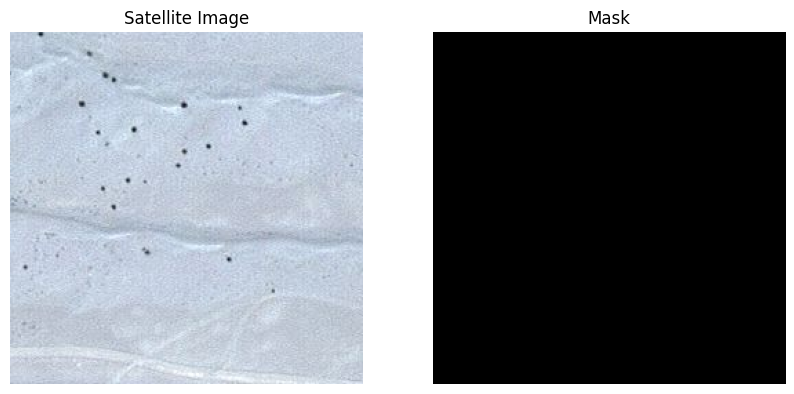

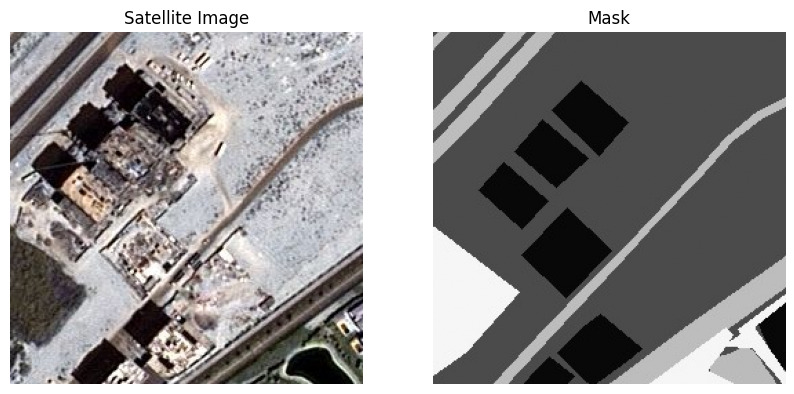

In [17]:
# Visualize Random Image + Mask Pairs
print("\n--- 3. Visualize Random Image + Mask Pairs ---")
def visualize_samples(images_dir, masks_dir, n=3):
    files = os.listdir(images_dir)
    samples = random.sample(files, n)
    for file in samples:
        img_path = os.path.join(images_dir, file)
        mask_path = os.path.join(masks_dir, file)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.title('Satellite Image')
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title('Mask')
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.show()

visualize_samples(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, n=3)

In [18]:
# Preprocessing Functions
def preprocess_image(img_path, target_size=(256,256)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img.astype(np.float32)

def preprocess_mask(mask_path, target_size=(256,256)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.float32)  # Threshold for binary mask
    return mask[..., np.newaxis]

In [19]:
class SatelliteSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = os.listdir(images_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)
        img = preprocess_image(img_path)
        mask = preprocess_mask(mask_path)
        img = torch.from_numpy(img).permute(2,0,1)
        mask = torch.from_numpy(mask).permute(2,0,1)
        if self.transform:
            img, mask = self.transform(img, mask)
        return img, mask

In [20]:
train_dataset = SatelliteSegmentationDataset(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR)
validation_dataset = SatelliteSegmentationDataset(VAL_IMAGES_DIR, VAL_MASKS_DIR)
test_dataset = SatelliteSegmentationDataset(TEST_IMAGES_DIR, TEST_MASKS_DIR)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 1296
Validation samples: 620
Test samples: 628


In [23]:
#  UNet Model Definition
print("\n--- 6. UNet Model Definition ---")
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.dconv_down1 = DoubleConv(n_channels, 32)
        self.dconv_down2 = DoubleConv(32, 64)
        self.dconv_down3 = DoubleConv(64, 128)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up2 = DoubleConv(128 + 64, 64)
        self.dconv_up1 = DoubleConv(64 + 32, 32)
        self.conv_last = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        x = self.dconv_down3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return torch.sigmoid(out)

model = UNet(n_channels=3, n_classes=1)
print(model)


--- 6. UNet Model Definition ---
UNet(
  (dconv_down1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down3): DoubleConv(
    (conv): Se

In [25]:
# Define Loss, Metrics & Optimizer

def dice_coeff(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, pred, target):
        return 1 - dice_coeff(pred, target)

bce_loss = nn.BCELoss()
dice_loss = DiceLoss()

def combined_loss(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [27]:
# Training Loop with Metric Tracking

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    epoch_loss = 0
    for imgs, masks in tqdm(dataloader, desc="Training"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def validate_epoch(model, dataloader, device, num_classes=2):
    model.eval()
    val_loss = 0
    val_dice = 0
    # Move the metric instance to the correct device
    miou_metric = MeanIoU(num_classes=num_classes, input_format="index", include_background=True).to(device)
    with torch.no_grad():
        for imgs, masks in tqdm(dataloader, desc="Validation"):
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coeff(outputs, masks).item()
            preds_binary = (outputs > 0.5).long()
            targets_binary = masks.long()
            preds_idx = preds_binary.squeeze(1)
            targets_idx = targets_binary.squeeze(1)
            miou_metric.update(preds_idx, targets_idx)
            preds_flat = preds_idx.view(-1)
            targets_flat = targets_idx.view(-1)
            val_pixel_acc = accuracy(preds_flat, targets_flat, task="multiclass", num_classes=num_classes)
    mean_iou_score = miou_metric.compute().item()
    miou_metric.reset()
    return val_loss / len(dataloader), val_dice / len(dataloader), mean_iou_score, val_pixel_acc.item()

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def save_checkpoint(model, optimizer, epoch, path="/content/drive/MyDrive/satellite_segmentation_data/models/latest_model.pth"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def load_checkpoint(model, optimizer, path="/content/drive/MyDrive/satellite_segmentation_data/models/latest_model.pth"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'] + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

early_stopper = EarlyStopping(patience=5, min_delta=0.001)
start_epoch = 0
checkpoint_path = "/content/drive/MyDrive/satellite_segmentation_data/models/latest_model.pth"

train_losses = []
val_losses = []
val_dice_scores = []
val_iou_scores = []
val_pixel_accuracies = []

if os.path.exists(checkpoint_path):
    print("Resuming from last checkpoint...")
    start_epoch = load_checkpoint(model, optimizer, path=checkpoint_path)
else:
    print("Starting training...")

num_epochs = 20
for epoch in range(start_epoch, num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_dice, val_iou, val_pixel_acc = validate_epoch(model, validation_loader, device, num_classes=2)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice)
    val_iou_scores.append(val_iou)
    val_pixel_accuracies.append(val_pixel_acc)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f} | Val Pixel Acc: {val_pixel_acc:.4f}")
    save_checkpoint(model, optimizer, epoch, path=checkpoint_path)
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping triggered — stopping training.")
        break

Using device: cuda
Starting training...

Epoch [1/20]


Validation: 100%|██████████| 155/155 [03:50<00:00,  1.49s/it]


Train Loss: 0.6678 | Val Loss: 0.5878 | Val Dice: 0.7132 | Val IoU: 0.6798 | Val Pixel Acc: 0.9222

Epoch [2/20]


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.18it/s]


Train Loss: 0.6192 | Val Loss: 0.5575 | Val Dice: 0.7270 | Val IoU: 0.6964 | Val Pixel Acc: 0.9245

Epoch [3/20]


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.51it/s]


Train Loss: 0.6021 | Val Loss: 0.5750 | Val Dice: 0.7393 | Val IoU: 0.6874 | Val Pixel Acc: 0.9251

Epoch [4/20]


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.99it/s]


Train Loss: 0.5978 | Val Loss: 0.5595 | Val Dice: 0.7252 | Val IoU: 0.7010 | Val Pixel Acc: 0.9276

Epoch [5/20]


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.89it/s]


Train Loss: 0.5983 | Val Loss: 0.7919 | Val Dice: 0.6743 | Val IoU: 0.6208 | Val Pixel Acc: 0.8973

Epoch [6/20]


Validation: 100%|██████████| 155/155 [00:10<00:00, 14.61it/s]


Train Loss: 0.5800 | Val Loss: 0.5613 | Val Dice: 0.7191 | Val IoU: 0.7021 | Val Pixel Acc: 0.9277

Epoch [7/20]


Validation: 100%|██████████| 155/155 [00:10<00:00, 15.21it/s]

Train Loss: 0.5682 | Val Loss: 0.5708 | Val Dice: 0.7173 | Val IoU: 0.7000 | Val Pixel Acc: 0.9240
Early stopping triggered — stopping training.



--- 9. Plotting Performance Metrics ---


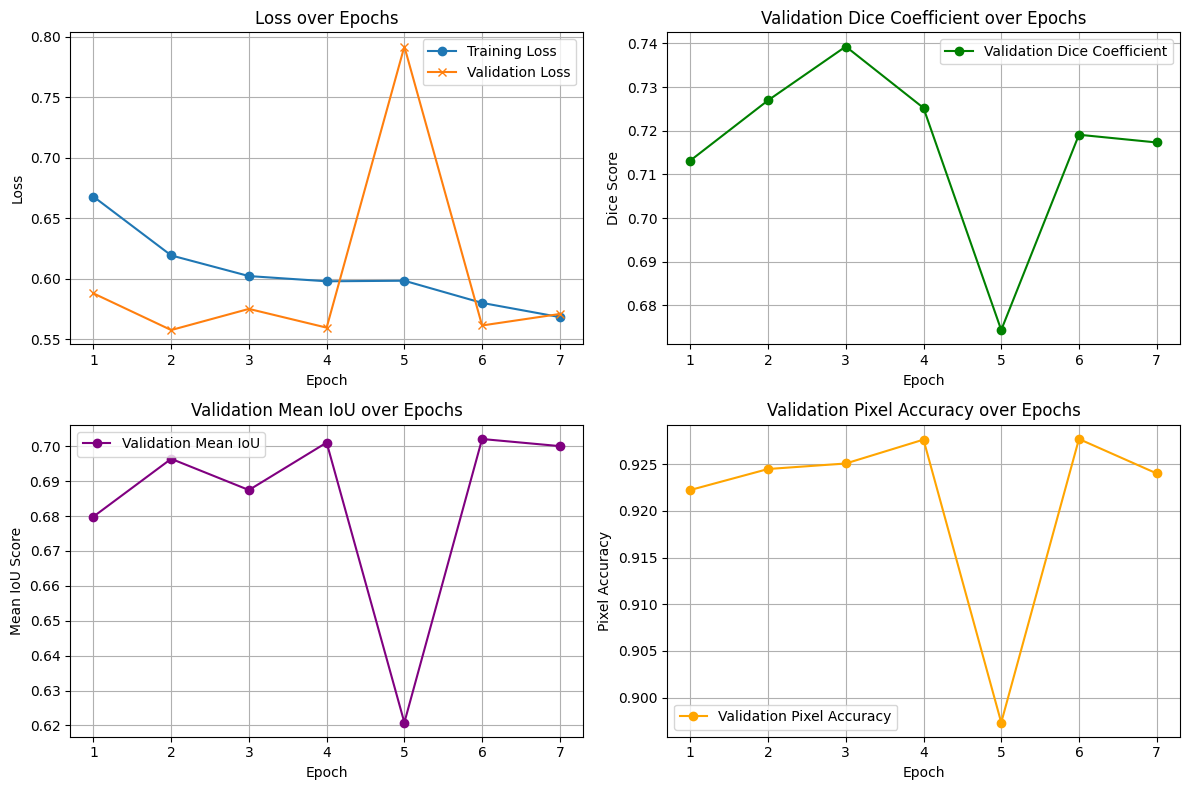

In [28]:
# Cell 12: Plotting Performance Metrics
print("\n--- 9. Plotting Performance Metrics ---")
epochs_ran = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs_ran, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_ran, val_losses, label='Validation Loss', marker='x')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_ran, val_dice_scores, label='Validation Dice Coefficient', marker='o', color='green')
plt.title('Validation Dice Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs_ran, val_iou_scores, label='Validation Mean IoU', marker='o', color='purple')
plt.title('Validation Mean IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU Score')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs_ran, val_pixel_accuracies, label='Validation Pixel Accuracy', marker='o', color='orange')
plt.title('Validation Pixel Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()




--- 10. Qualitative Visualization of Test Predictions ---
Visualizing predictions on test set...


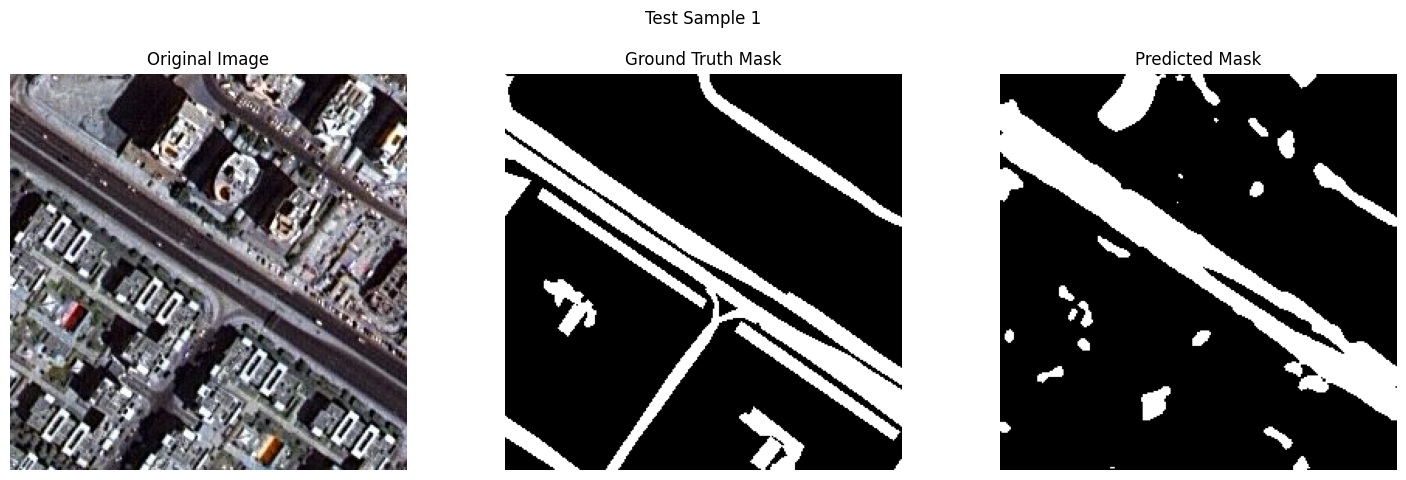

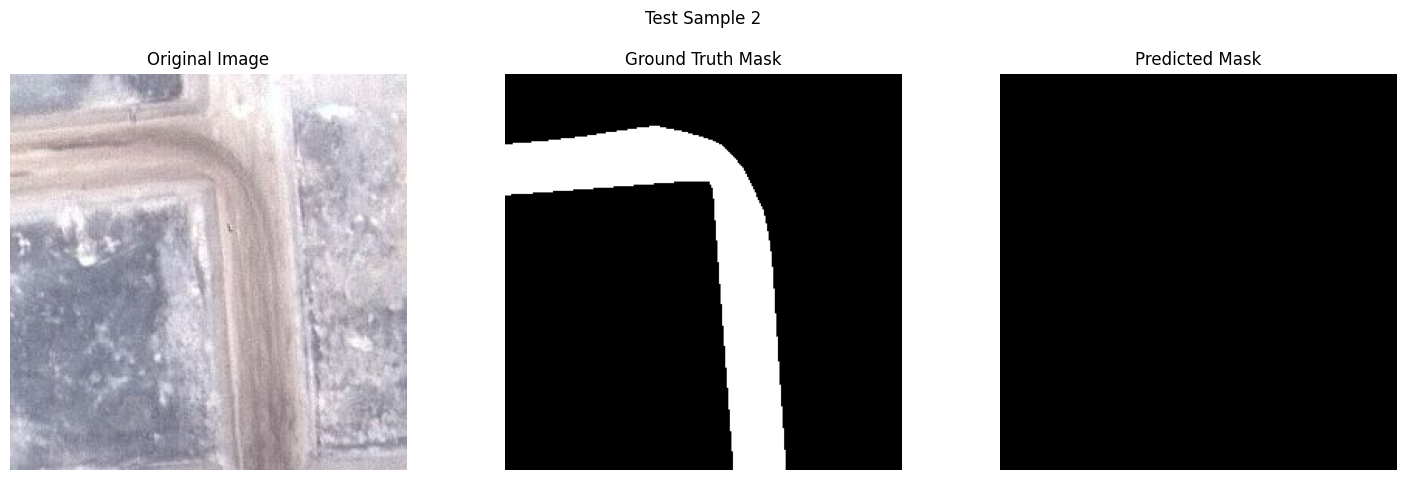

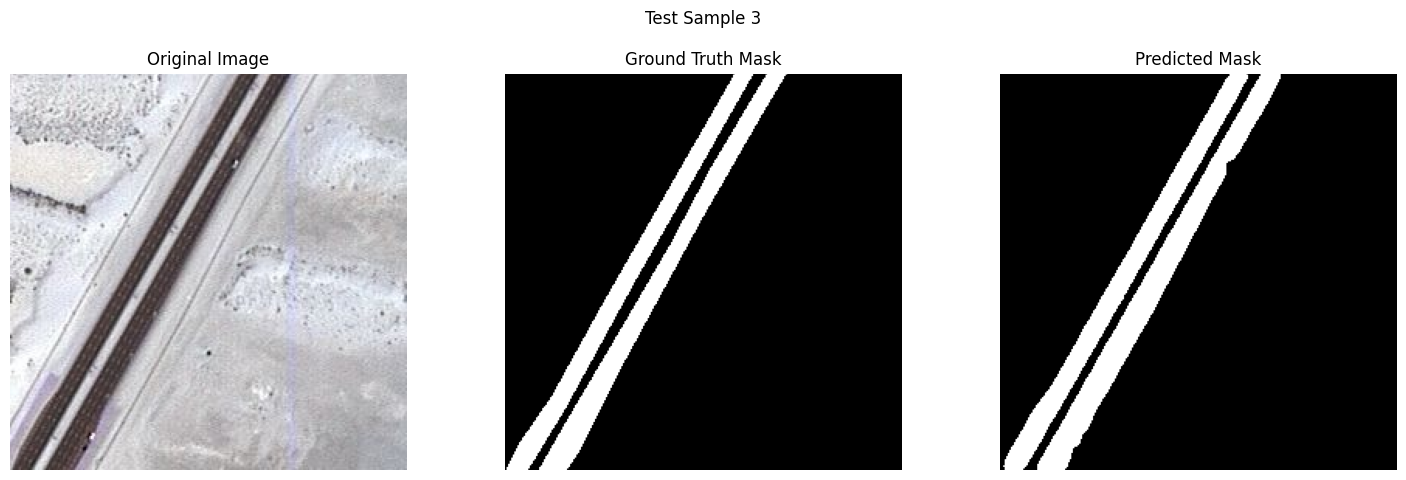

In [29]:
def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    samples_to_show = []
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(dataloader):
            if len(samples_to_show) >= num_samples:
                break
            imgs = imgs.to(device)
            outputs = model(imgs)
            for j in range(imgs.size(0)):
                if len(samples_to_show) >= num_samples:
                    break
                img = imgs[j].cpu().permute(1, 2, 0).numpy()
                true_mask = masks[j].cpu().squeeze().numpy()
                pred_mask = (outputs[j].cpu().squeeze().numpy() > 0.5).astype(np.float32)
                samples_to_show.append((img, true_mask, pred_mask))

    for i, (img, true_mask, pred_mask) in enumerate(samples_to_show):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        axes[1].imshow(true_mask, cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')
        axes[2].imshow(pred_mask, cmap='gray')
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')
        plt.suptitle(f'Test Sample {i+1}')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

print("Visualizing predictions on test set...")
visualize_predictions(model, test_loader, device, num_samples=3)


